<a href="https://colab.research.google.com/github/SarangMohrir/Angular/blob/main/task1_clustering_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# link to dataset - [heart data](https://https://github.com/paliwalamol/Datasets/blob/main/heart.csv)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=7df38b78554b717381a2e6a1c93d90c953dd7963ab83d5dc9b064a59e9437150
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
! pip install scikit-learn


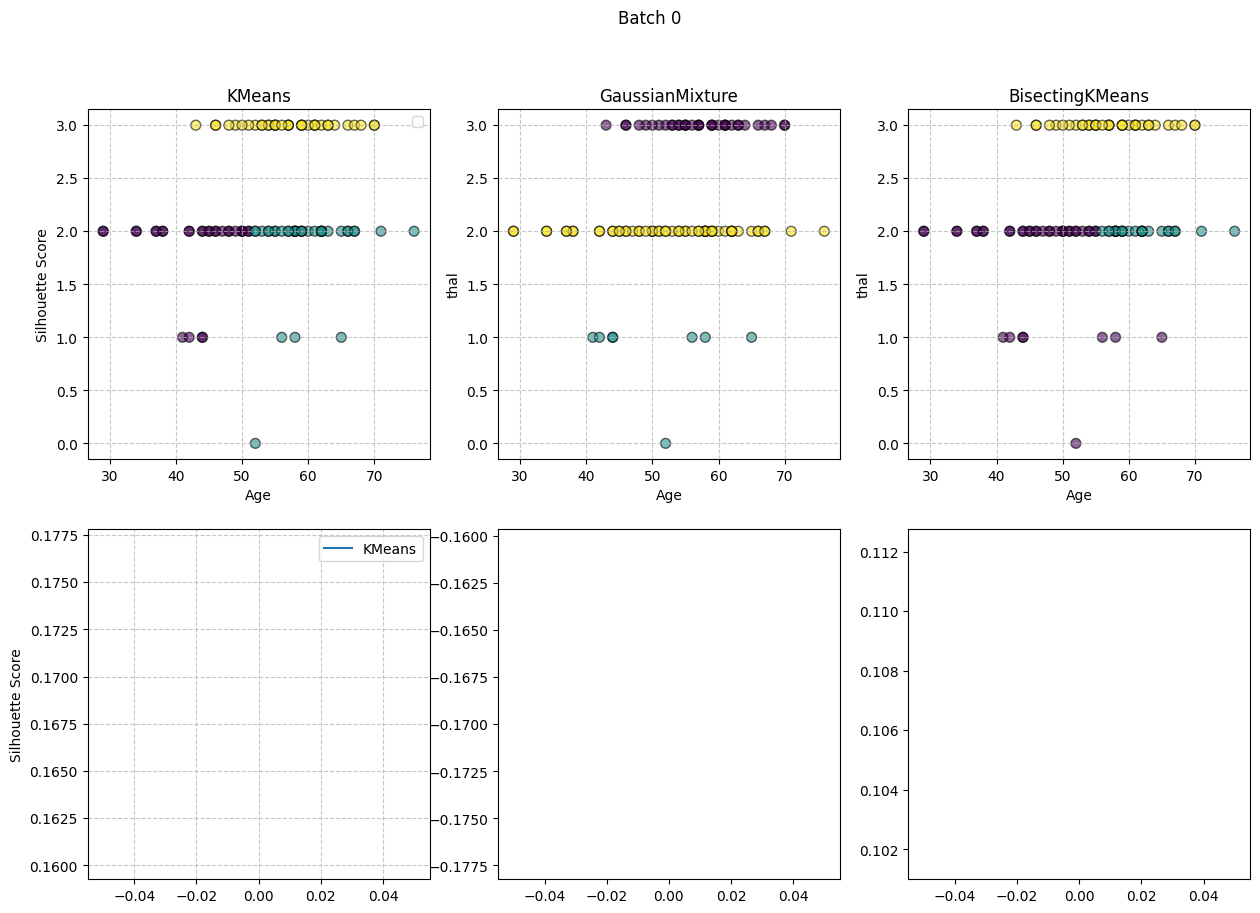

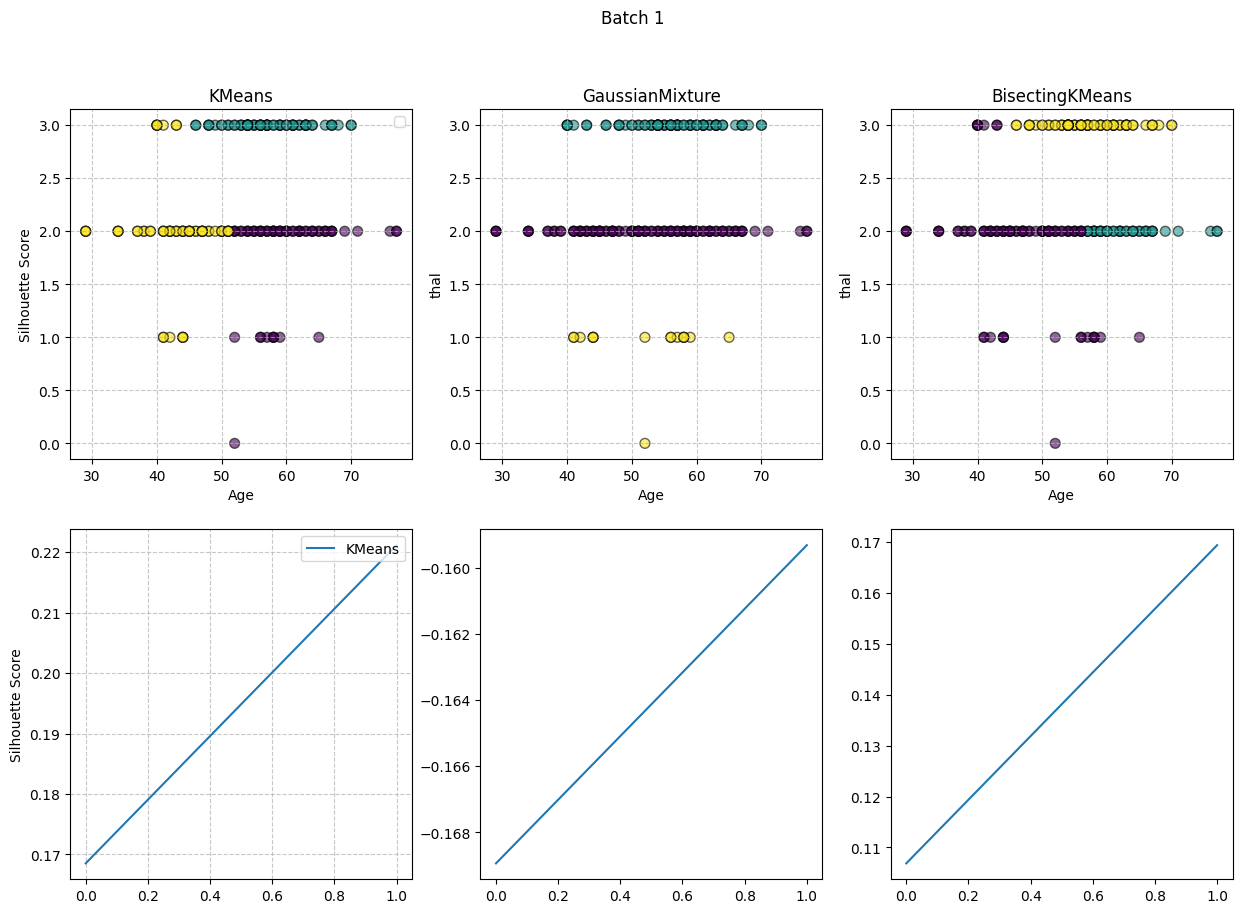

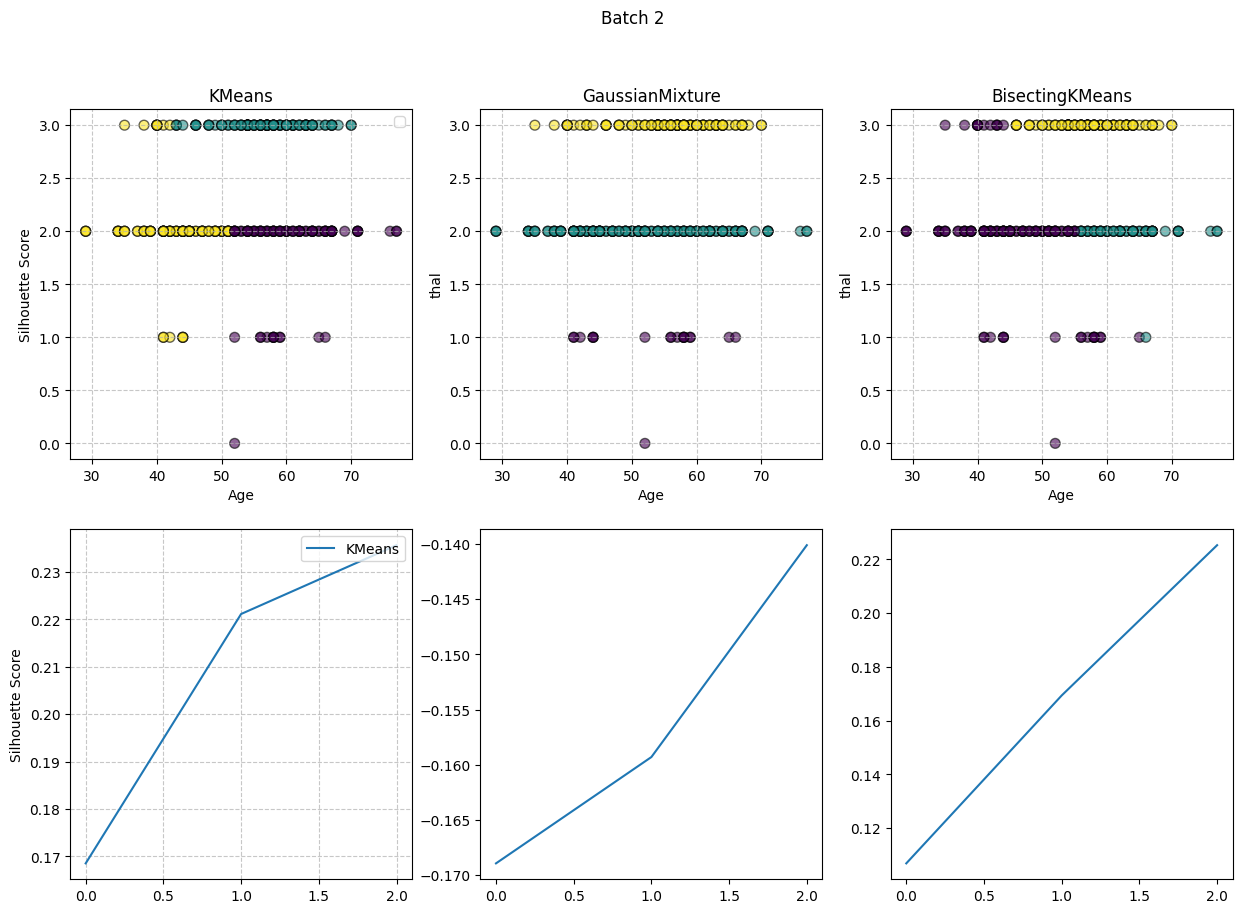

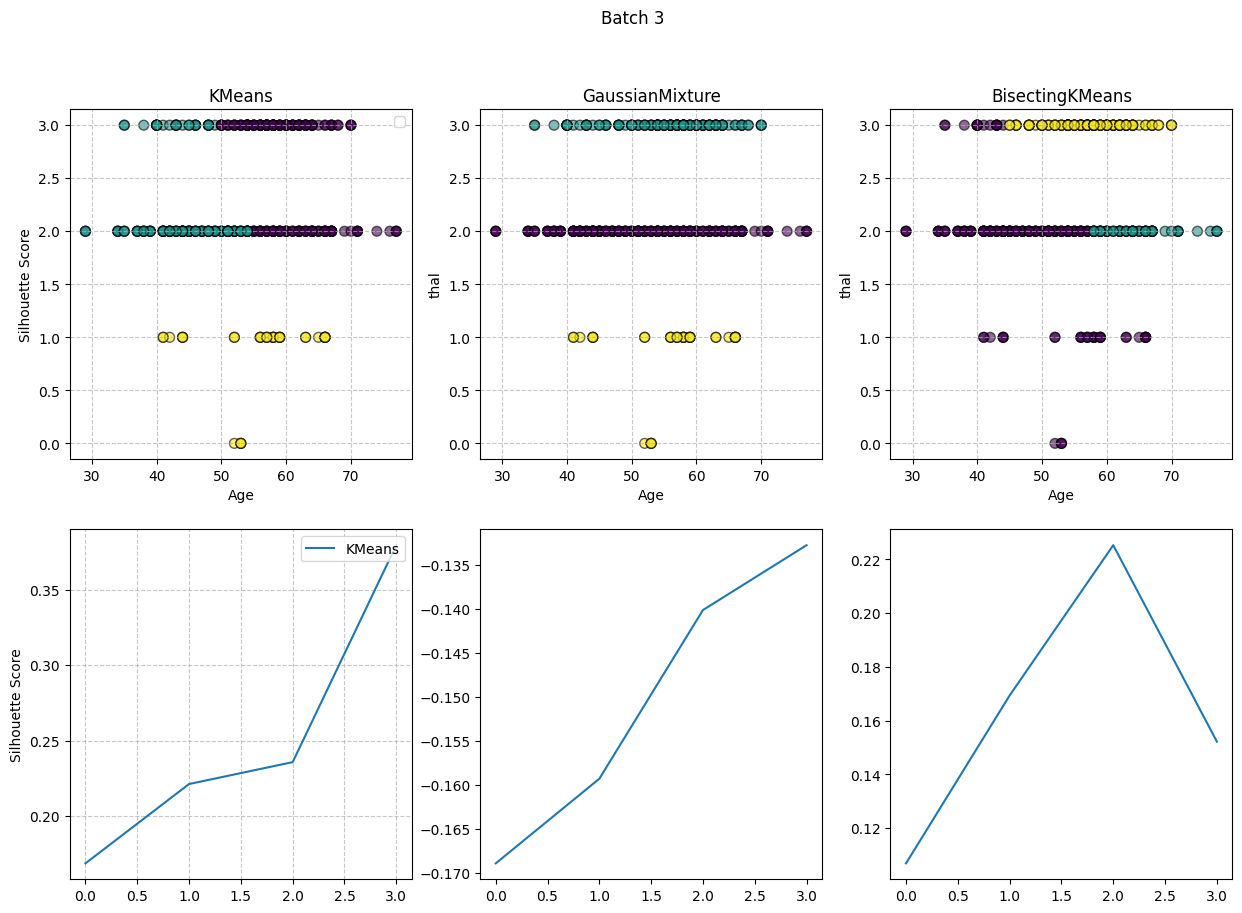

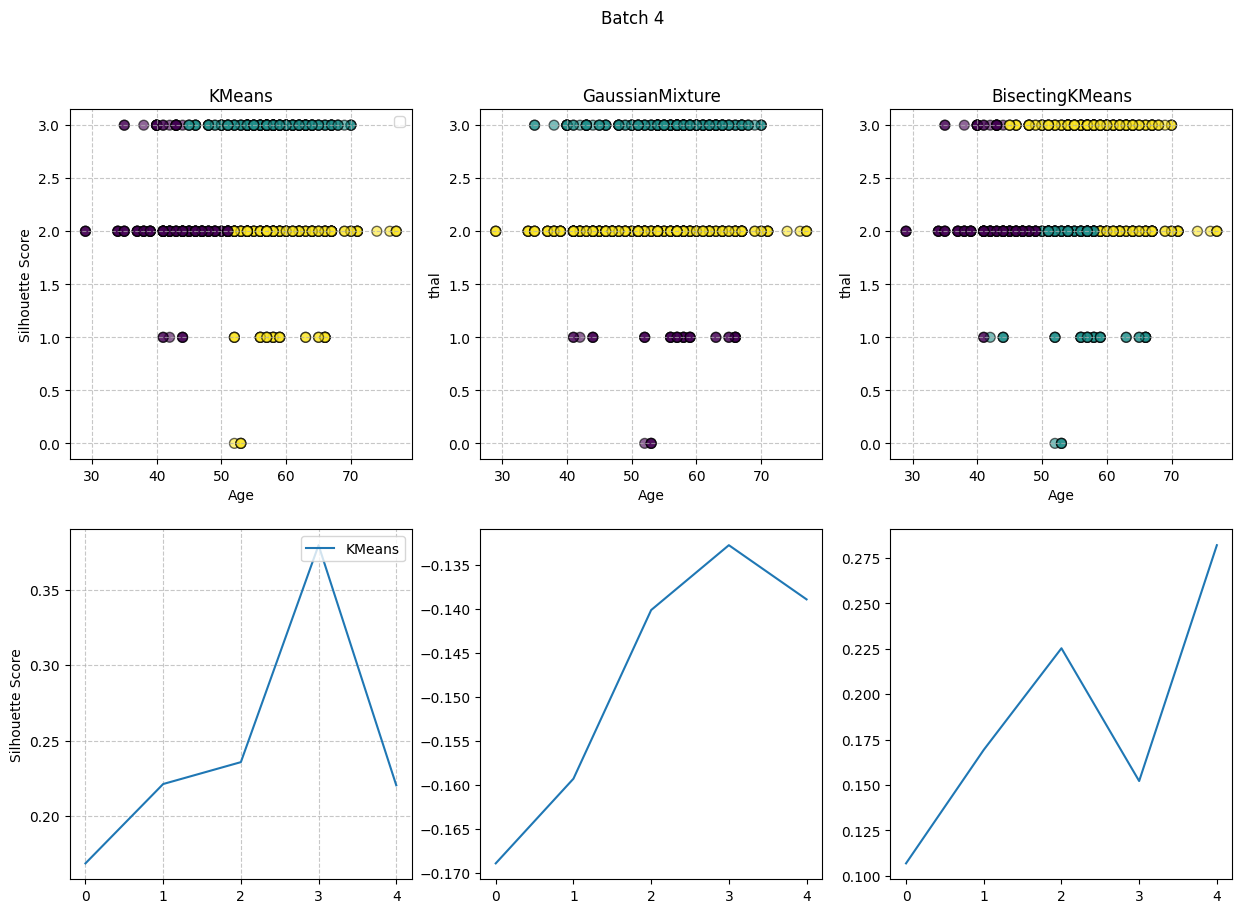

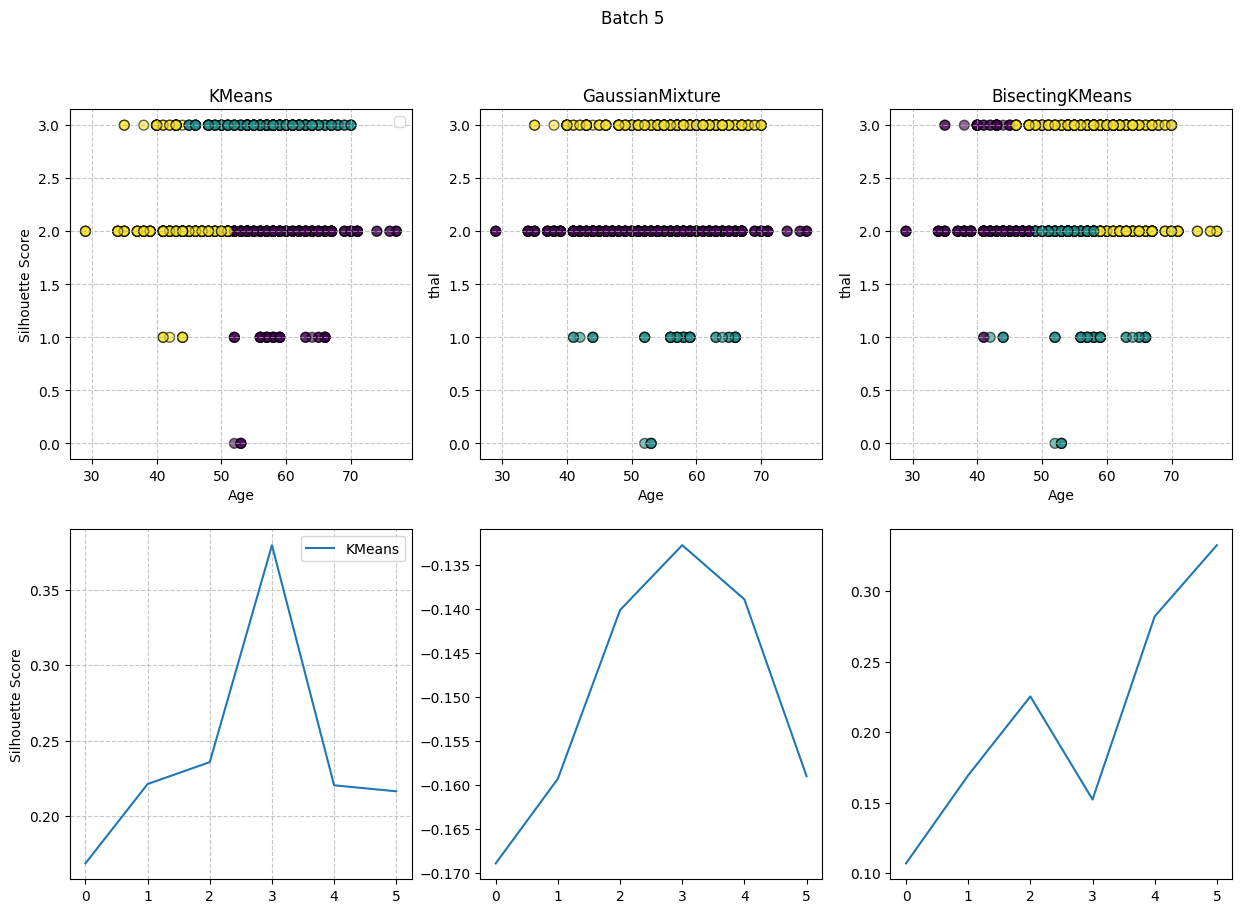

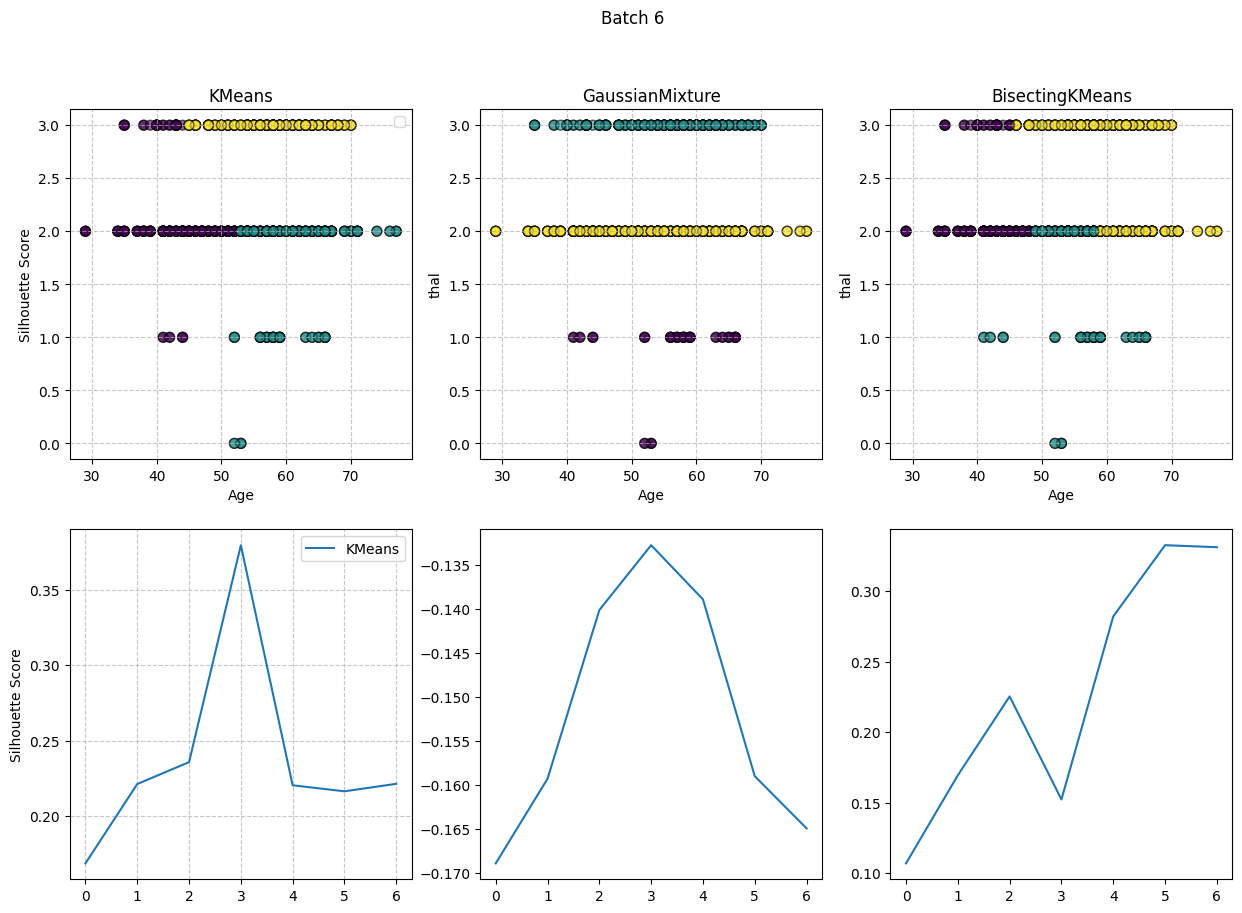

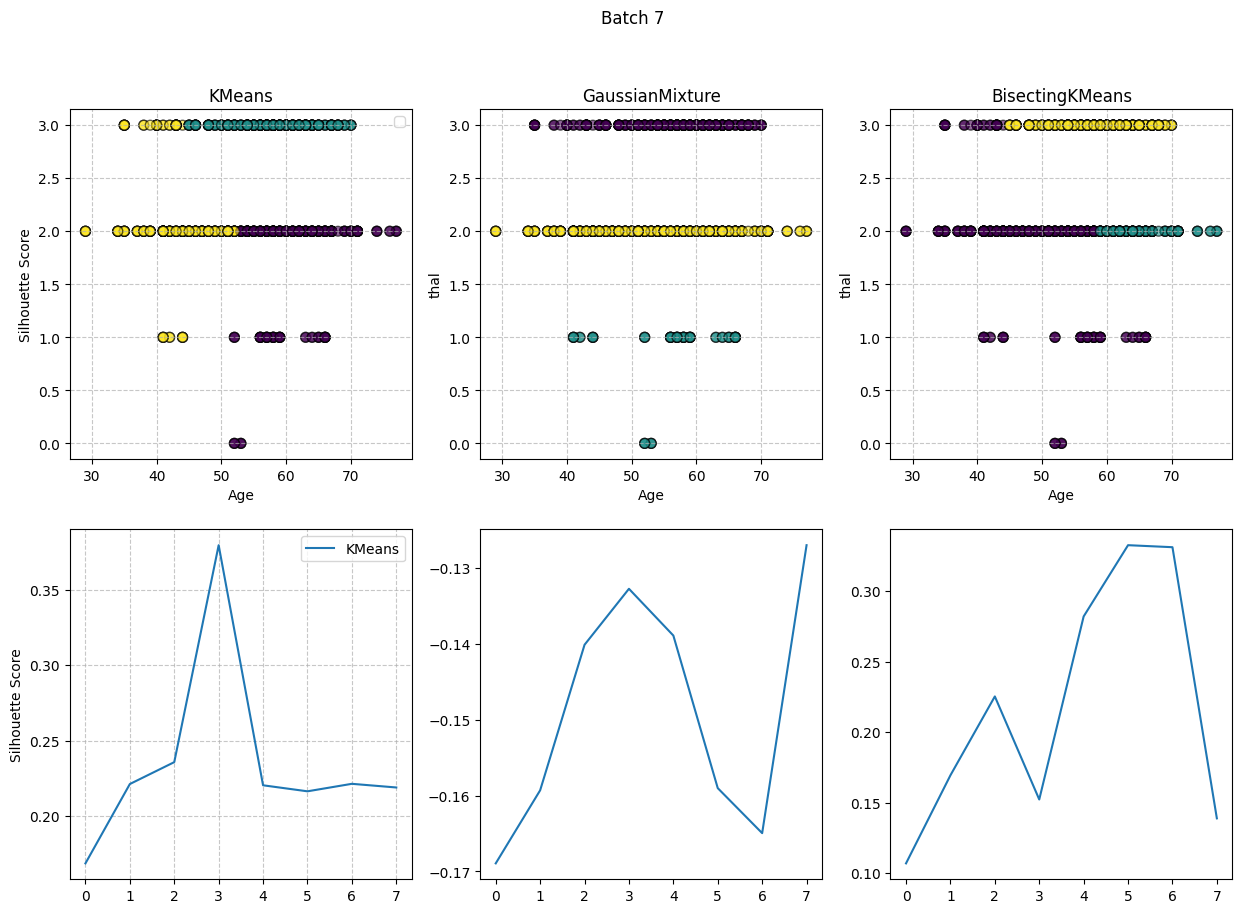

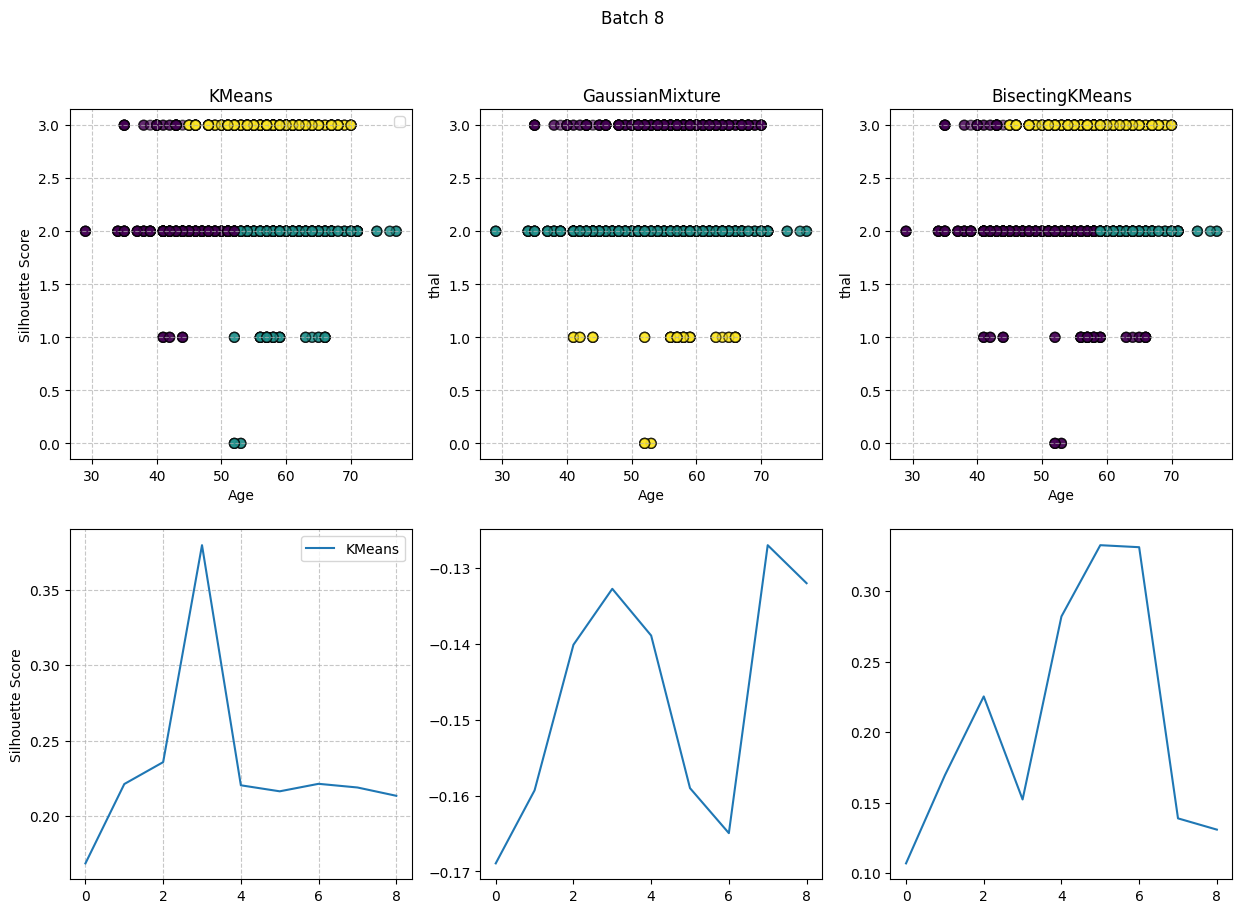

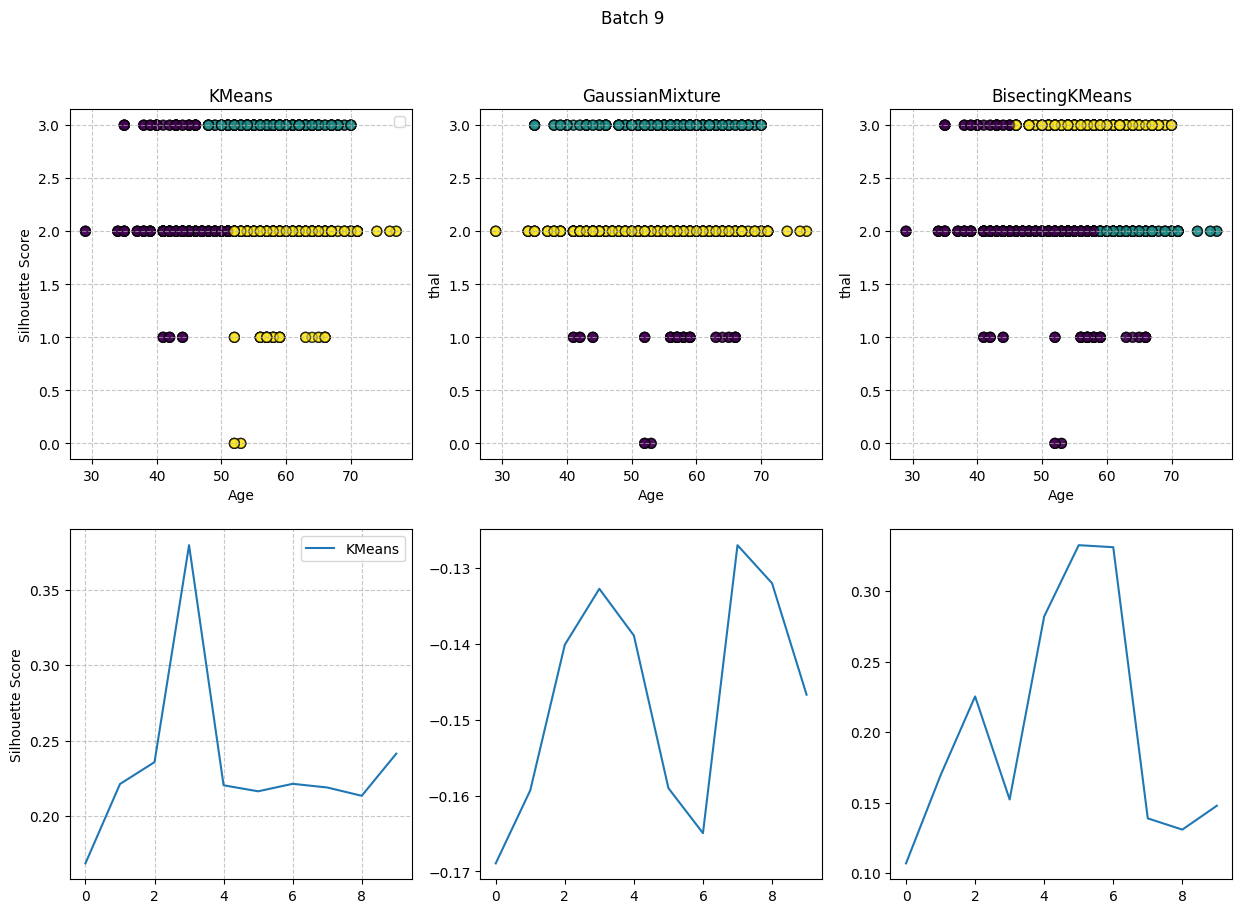

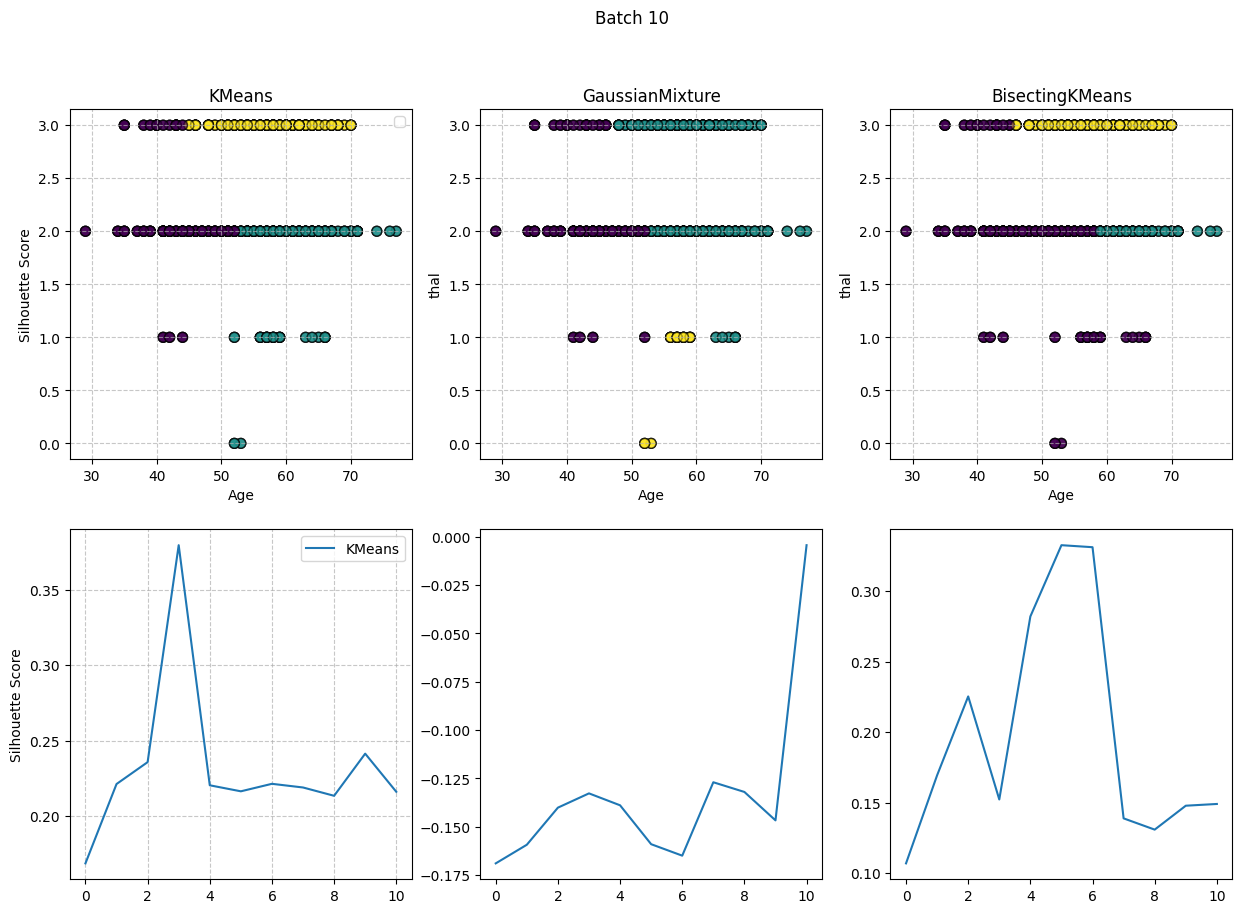

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Set up a Spark session
spark = SparkSession.builder.appName("HeartClustering").getOrCreate()

# Load the data (adjust path accordingly)
file_path = "/content/drive/MyDrive/Colab Notebooks/Stream data processing/heart.csv+
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Select relevant features (adjust as needed)
selected_features = ["age", "thal"]
df = df.select(*selected_features)

# Drop rows with missing values
df = df.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Clustering algorithms
clustering_algorithms = [
    KMeans(featuresCol="scaled_features", k=3, seed=42),
    GaussianMixture(featuresCol="scaled_features", k=3, seed=42),
    BisectingKMeans(featuresCol="scaled_features", k=3, seed=42),
]

# Process data in batches and visualize intermediate results for each algorithm
batch_size = 100
num_batches = df.count() // batch_size

# Initialize lists to store silhouette scores for each algorithm
silhouette_scores_kmeans = []
silhouette_scores_gaussian = []
silhouette_scores_bisecting_kmeans = []

for batch_num in range(num_batches + 1):
    # Read a batch of data
    batch_df = df.limit((batch_num + 1) * batch_size)

    # Check if the batch DataFrame is not empty
    if not batch_df.isEmpty():
        # Set up subplots for each algorithm and silhouette scores
        fig, axes = plt.subplots(nrows=2, ncols=len(clustering_algorithms), figsize=(15, 10))
        fig.suptitle(f"Batch {batch_num}")

        for i, algorithm in enumerate(clustering_algorithms):
            # Fit the clustering model
            model = algorithm.fit(batch_df)

            # Make predictions
            predictions = model.transform(batch_df)

            # Convert DataFrame to Pandas for visualization
            pandas_df = predictions.select(*selected_features, "prediction").toPandas()

            # Plot clusters
            axes[0, i].scatter(pandas_df["age"], pandas_df["thal"], c=pandas_df["prediction"], cmap='viridis', edgecolors='k', s=50, alpha=0.6)
            axes[0, i].set_title(algorithm.__class__.__name__)
            axes[0, i].set_xlabel("Age")
            axes[0, i].set_ylabel("thal")
            axes[0, i].grid(True, linestyle="--", alpha=0.7)

            # Evaluate clustering performance using silhouette score
            evaluator = ClusteringEvaluator()
            silhouette_score = evaluator.evaluate(predictions)

            # Append silhouette score to the respective list
            if algorithm.__class__.__name__ == "KMeans":
                silhouette_scores_kmeans.append(silhouette_score)
            elif algorithm.__class__.__name__ == "GaussianMixture":
                silhouette_scores_gaussian.append(silhouette_score)
            elif algorithm.__class__.__name__ == "BisectingKMeans":
                silhouette_scores_bisecting_kmeans.append(silhouette_score)

        # Plot silhouette scores with labels
        axes[1, 0].plot(silhouette_scores_kmeans, label="KMeans")
        axes[1, 1].plot(silhouette_scores_gaussian, label="Gaussian Mixture")
        axes[1, 2].plot(silhouette_scores_bisecting_kmeans, label="Bisecting KMeans")

        # Set labels and legend for silhouette score plots
        for i in range(2):
            axes[i, 0].set_ylabel("Silhouette Score")
            axes[i, 0].legend(loc="upper right")
            axes[i, 0].grid(True, linestyle="--", alpha=0.7)

        plt.show()


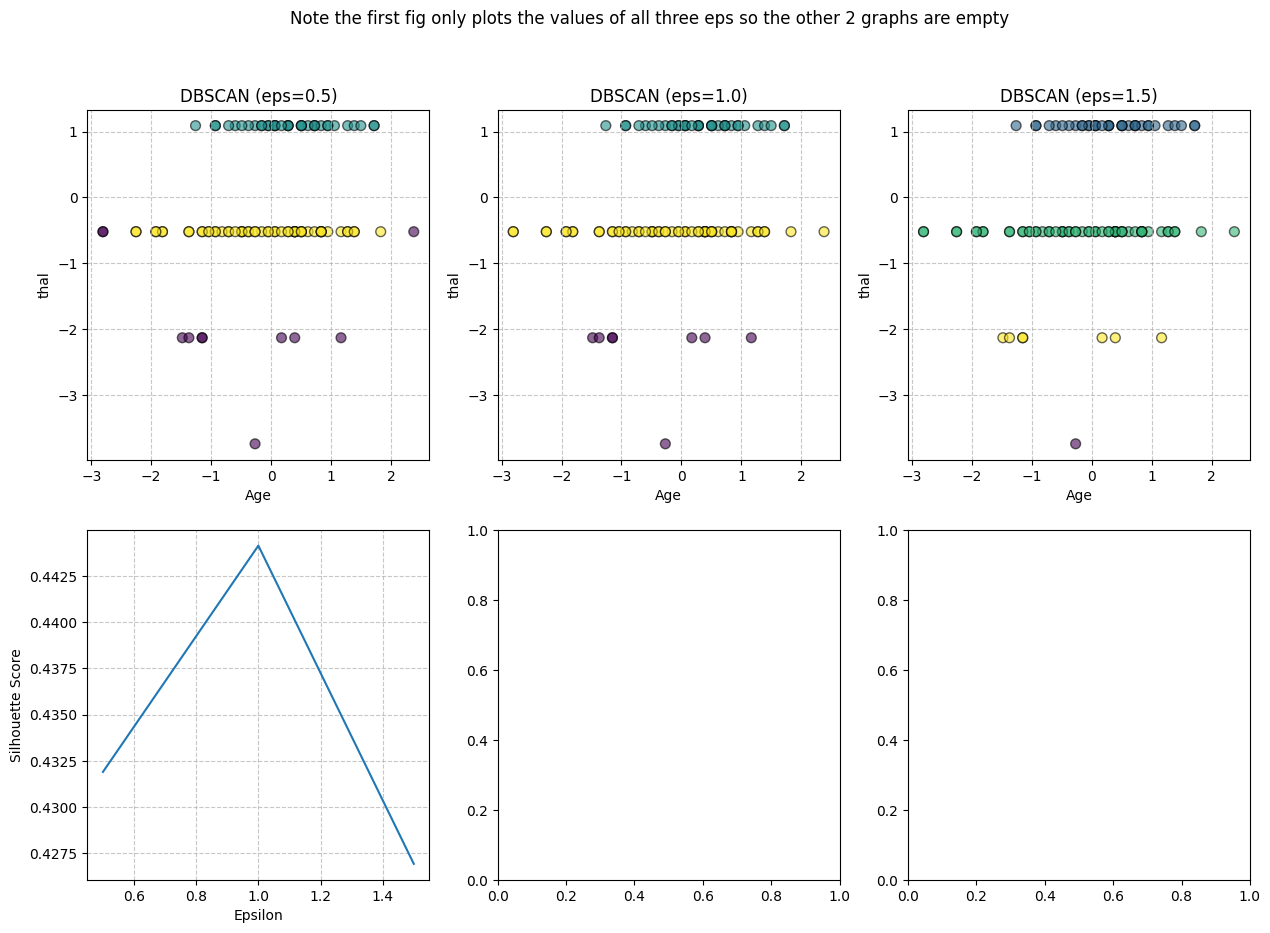

Optimal number of clusters for Batch 0: 4 (eps=1.0)


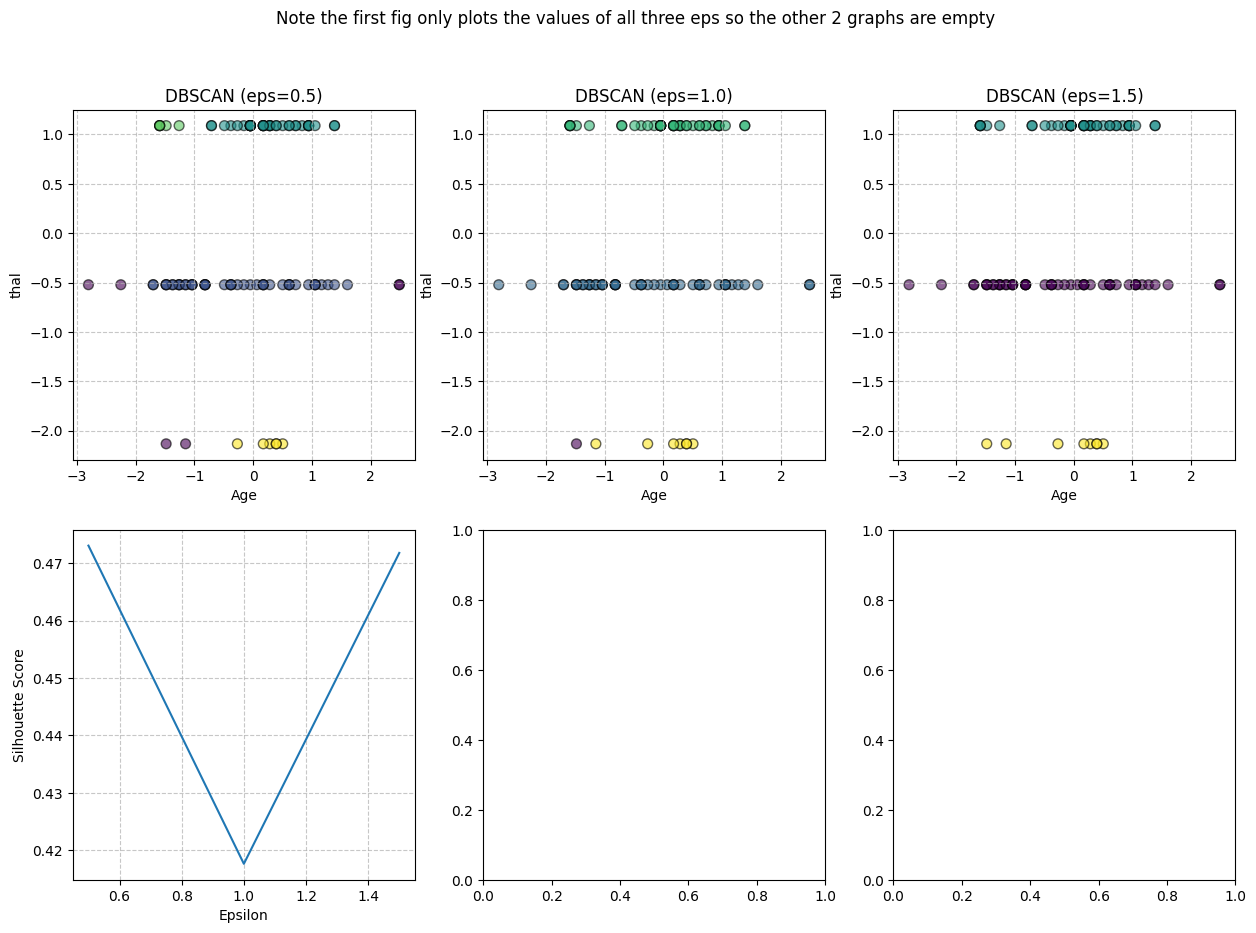

Optimal number of clusters for Batch 1: 3 (eps=0.5)


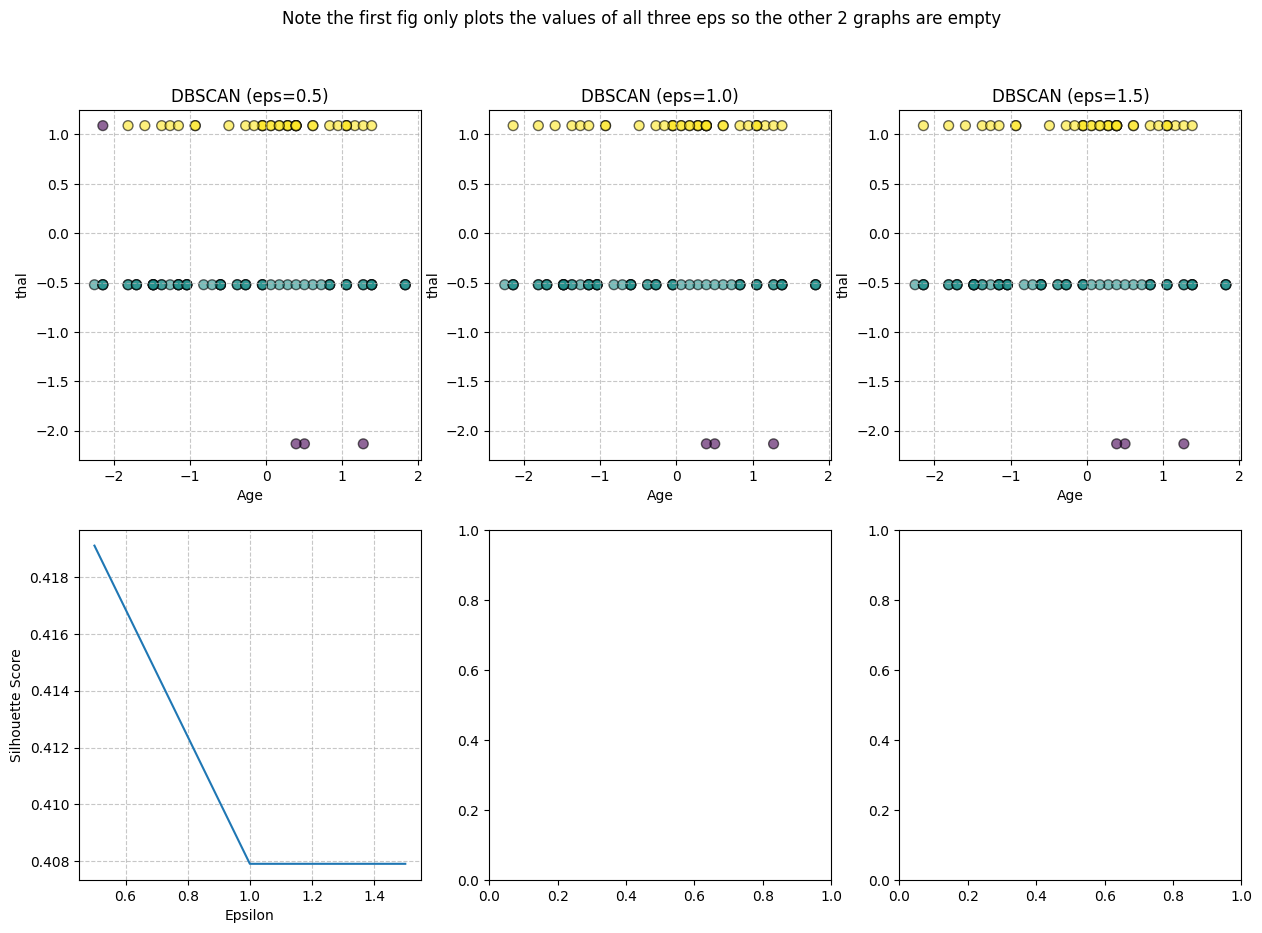

Optimal number of clusters for Batch 2: 3 (eps=0.5)


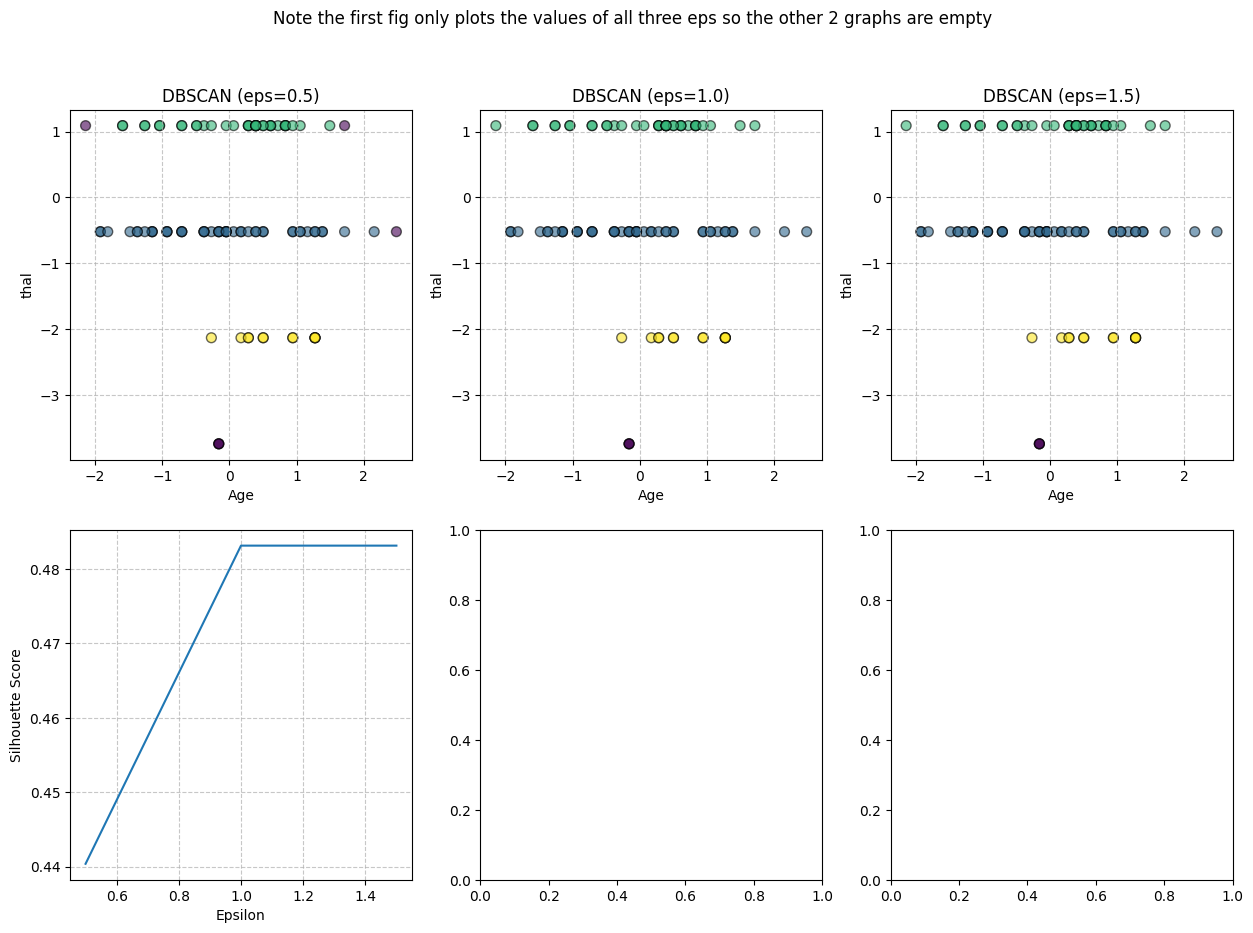

Optimal number of clusters for Batch 3: 4 (eps=1.0)


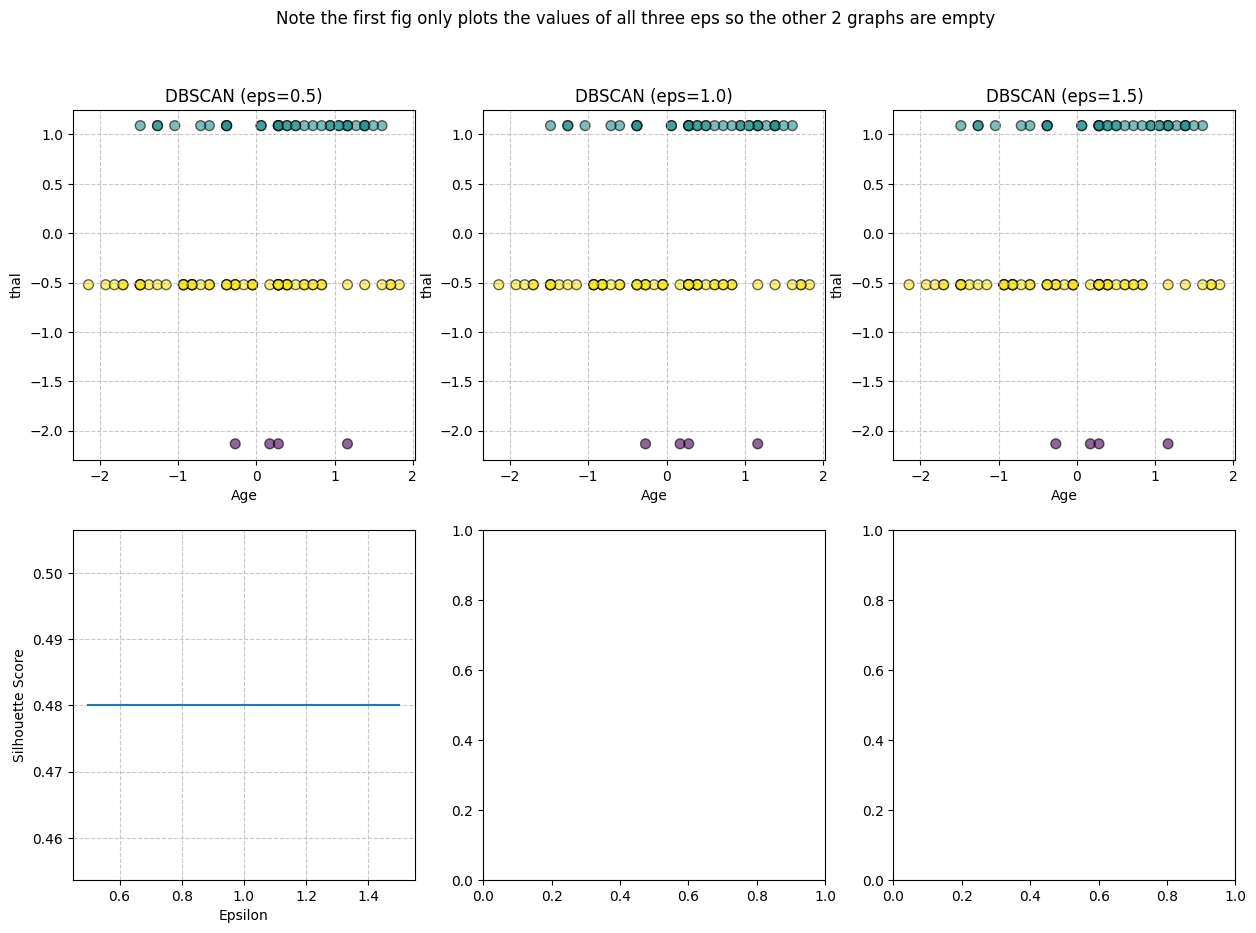

Optimal number of clusters for Batch 4: 3 (eps=0.5)


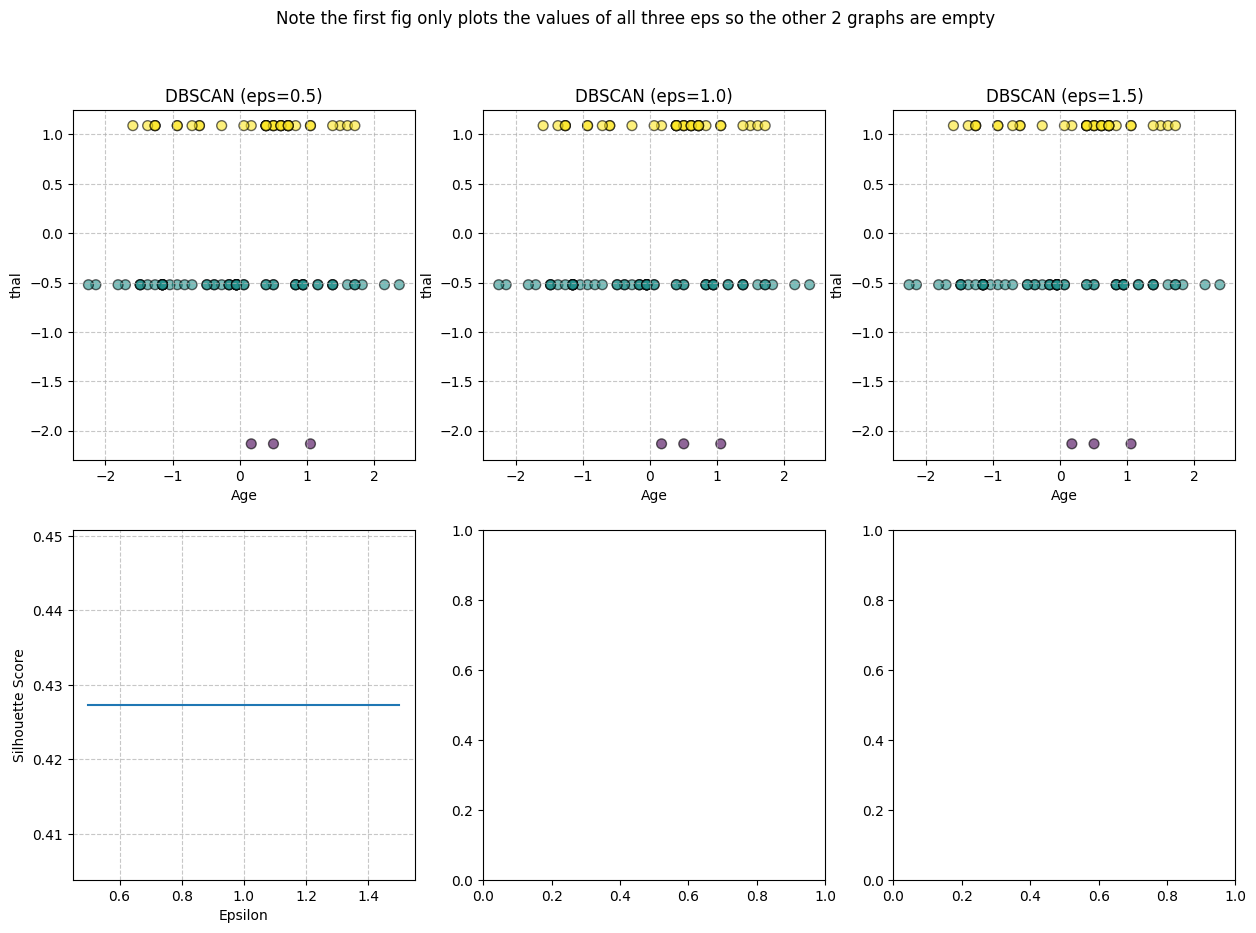

Optimal number of clusters for Batch 5: 3 (eps=0.5)


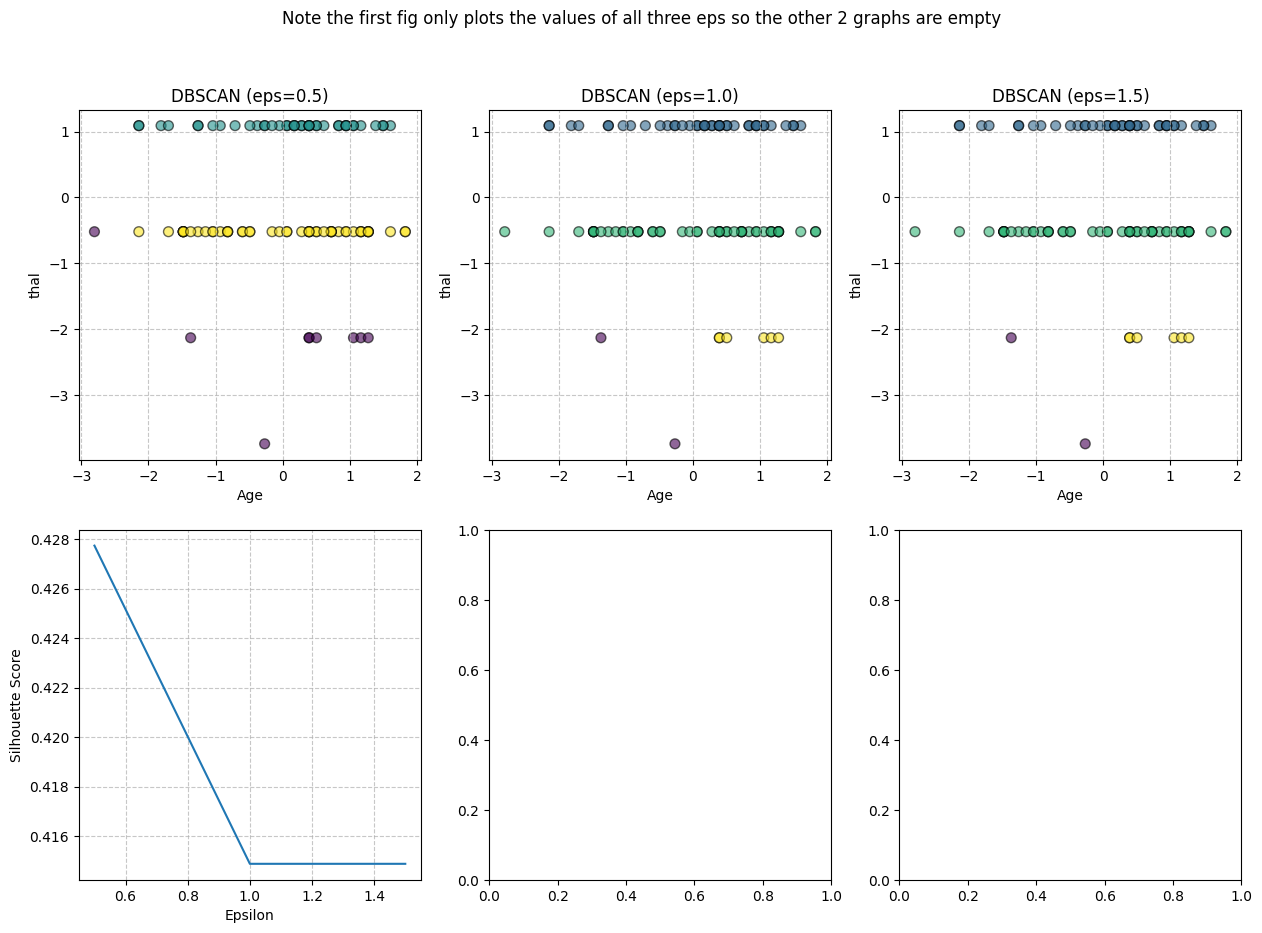

Optimal number of clusters for Batch 6: 4 (eps=0.5)


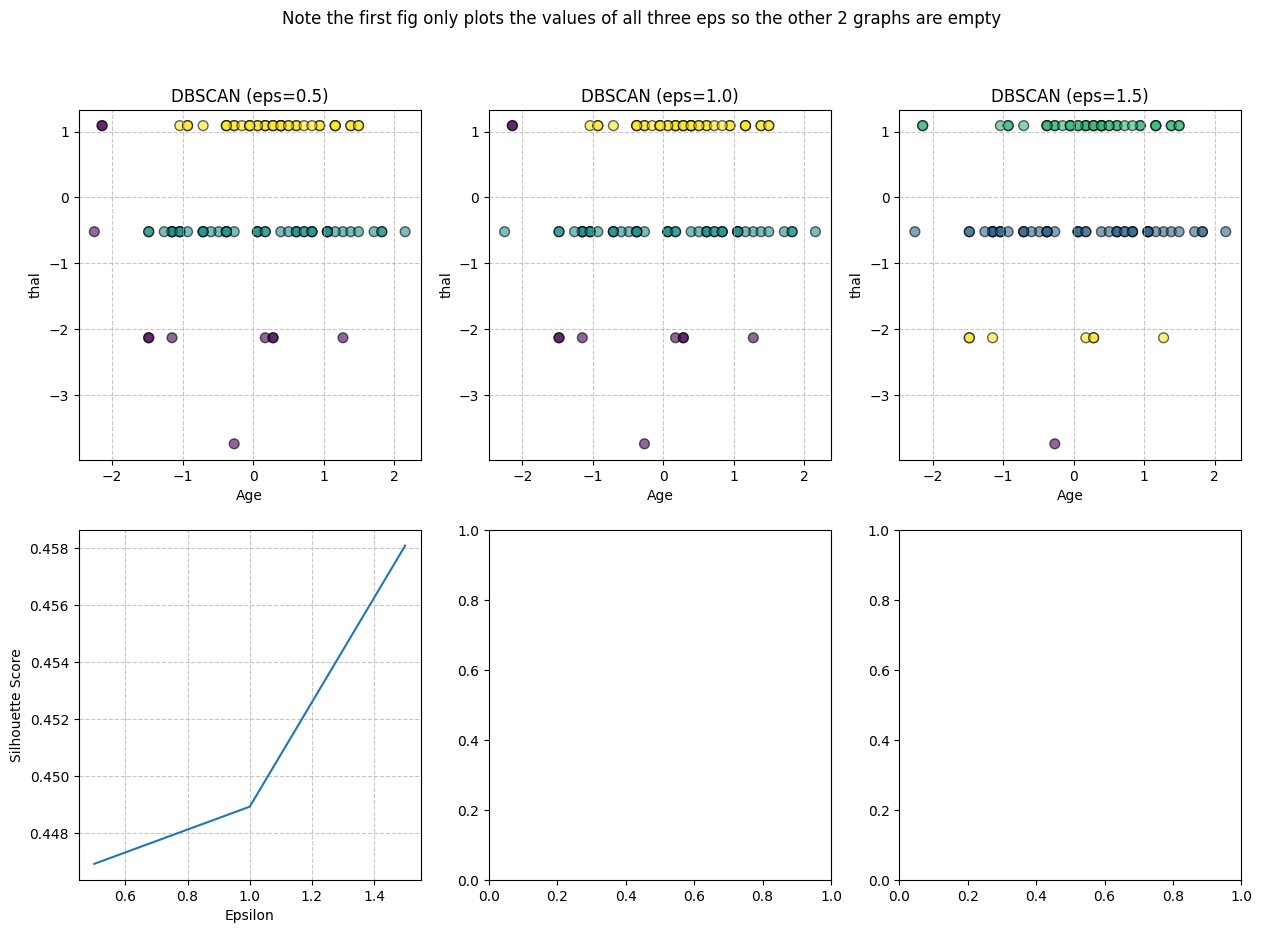

Optimal number of clusters for Batch 7: 4 (eps=1.5)


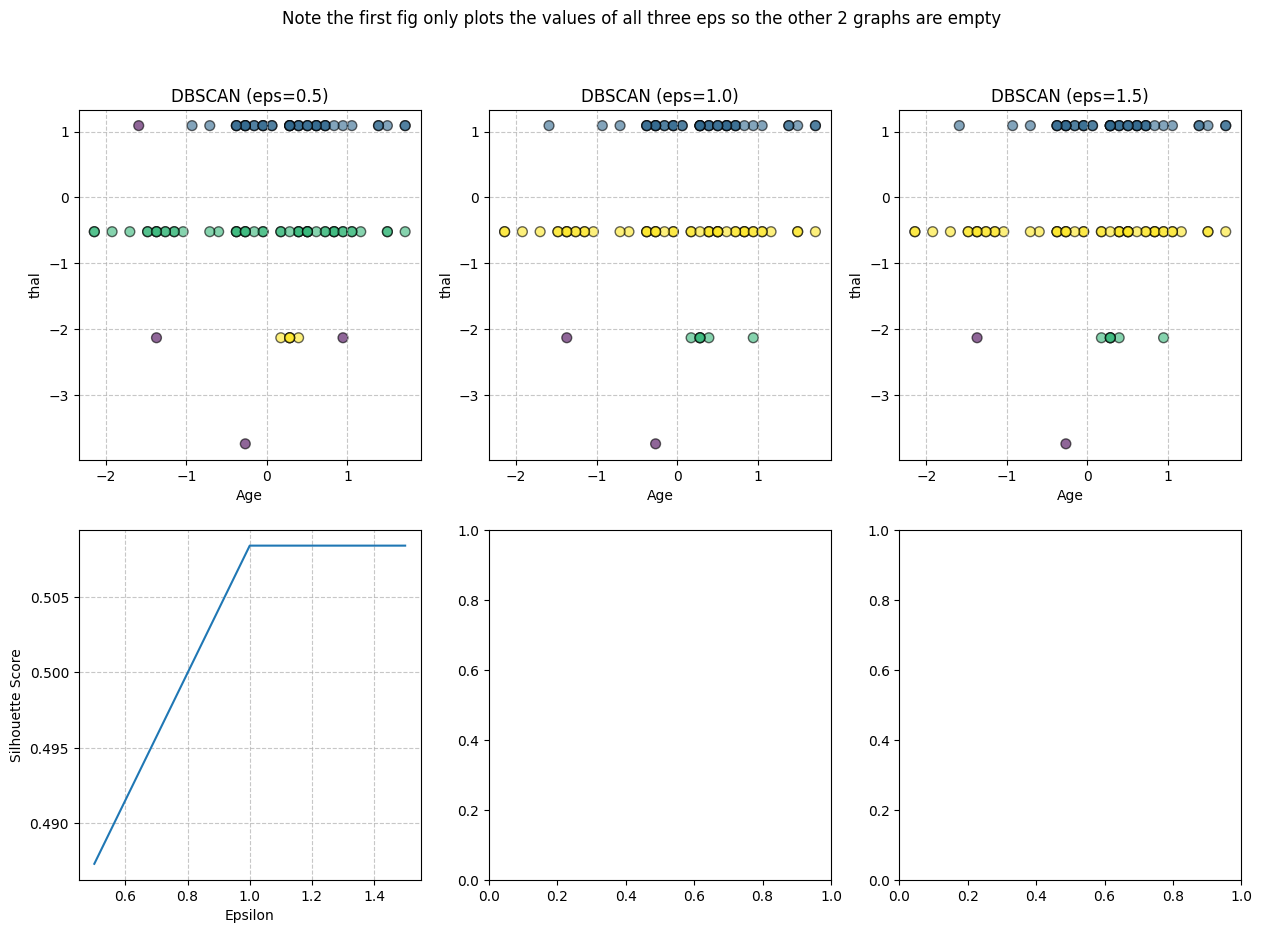

Optimal number of clusters for Batch 8: 4 (eps=1.0)


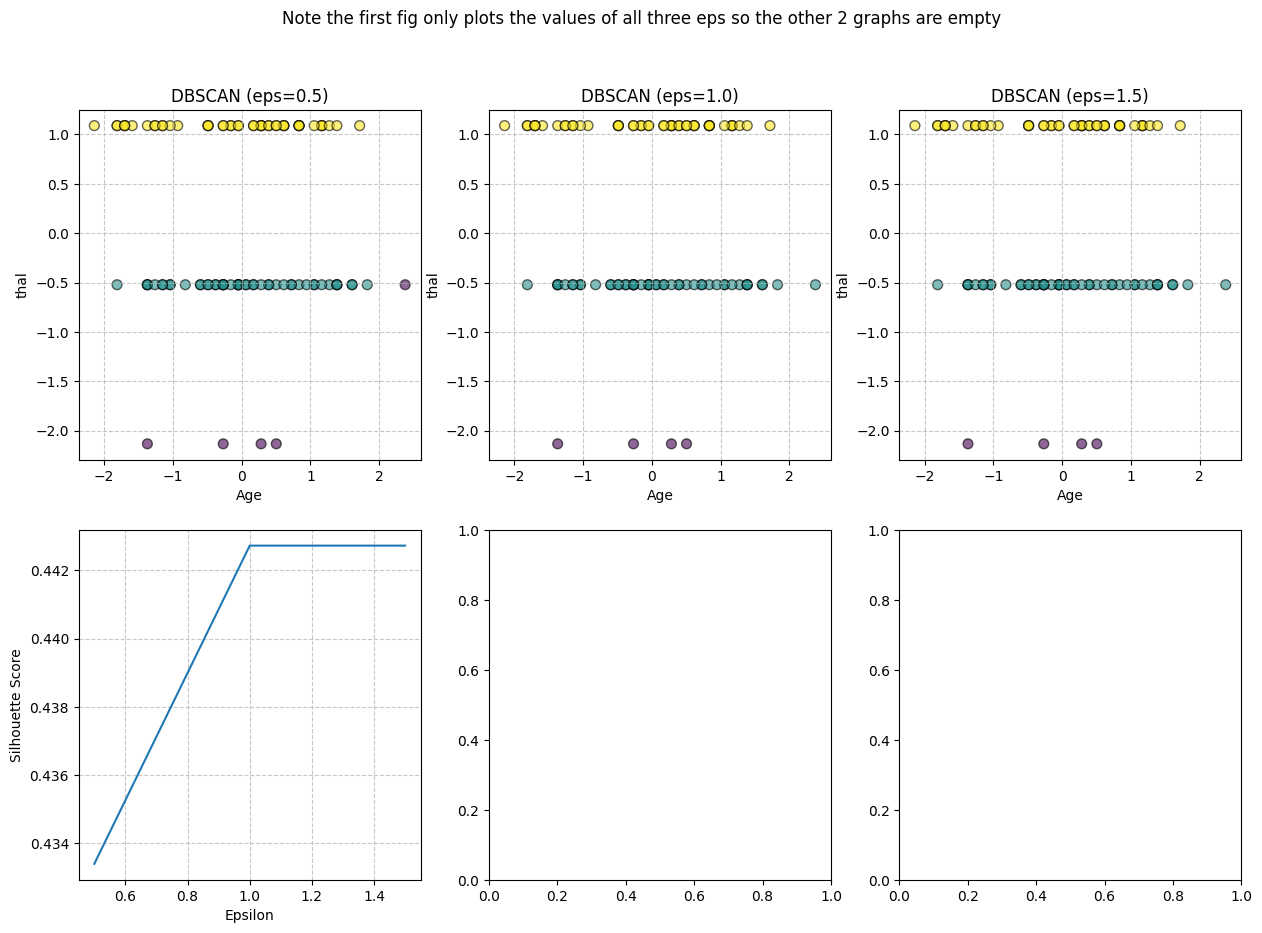

Optimal number of clusters for Batch 9: 3 (eps=1.0)


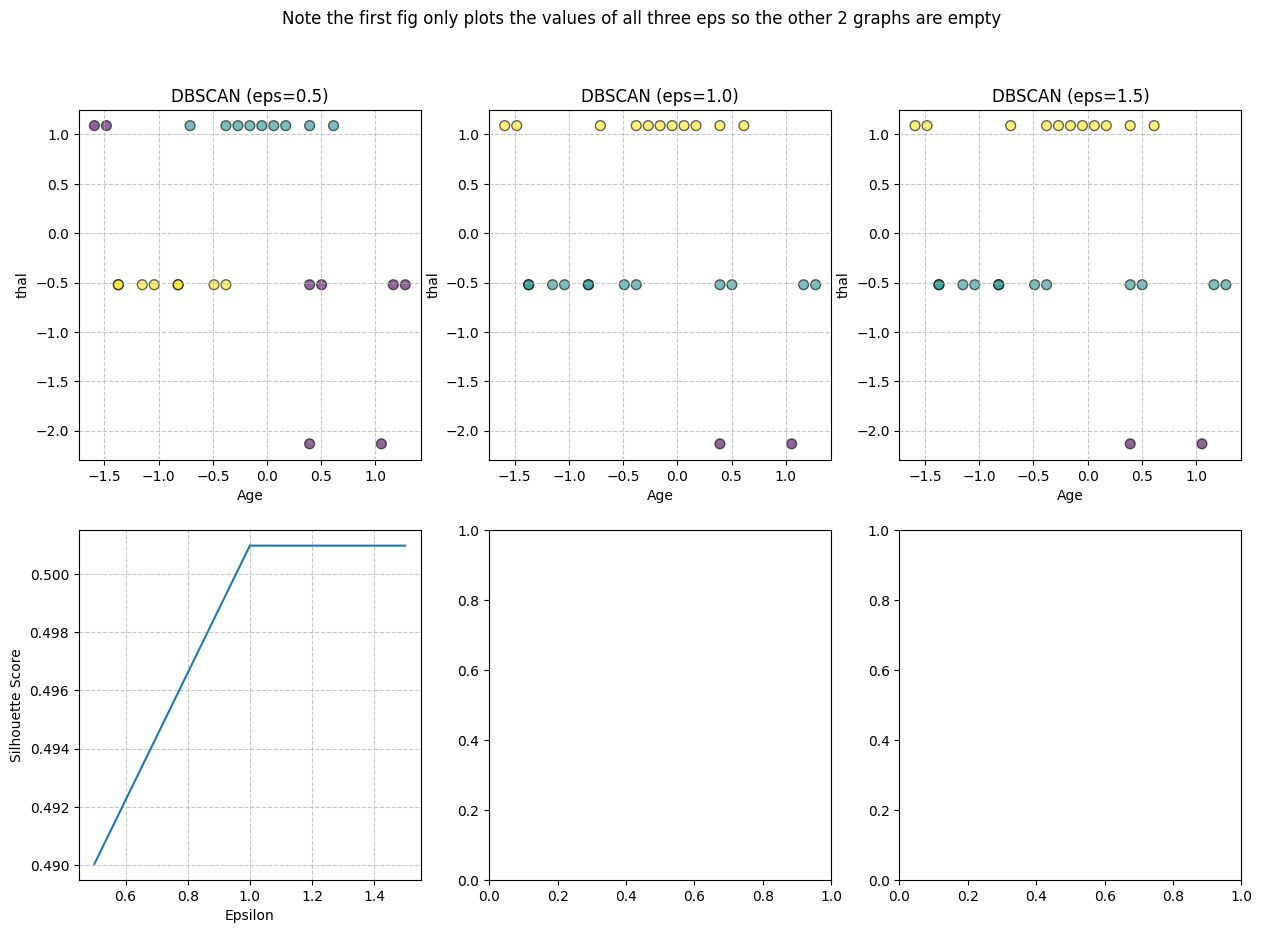

Optimal number of clusters for Batch 10: 3 (eps=1.0)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (adjust path accordingly)
file_path = "/content/drive/MyDrive/Colab Notebooks/Stream data processing/heart.csv"
df = pd.read_csv(file_path)

# Select relevant features (adjust as needed)
selected_features = ["age", "thal"]
df = df[selected_features]

# Drop rows with missing values
df = df.dropna()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# DBSCAN parameters
eps_values = [0.5, 1.0, 1.5]  # Adjust as needed
min_samples = 5  # Adjust as needed

# Process data in batches and visualize intermediate results for each epsilon
batch_size = 100
num_batches = len(df) // batch_size

for batch_num in range(num_batches + 1):
    # Read a batch of data
    start_row = batch_num * batch_size
    end_row = start_row + batch_size
    batch_data = scaled_features[start_row:end_row]

    # Check if the batch is not empty
    if len(batch_data) > 0:
        # Set up subplots for each epsilon
        fig, axes = plt.subplots(nrows=2, ncols=len(eps_values), figsize=(15, 10))
        fig.suptitle(f"Batch {batch_num}")
        fig.suptitle(f"Note the first fig only plots the values of all three eps so the other 2 graphs are empty")

        # Initialize lists to store silhouette scores for each epsilon
        silhouette_scores = []

        for i, eps in enumerate(eps_values):
            # Fit the DBSCAN model
            dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan_model.fit_predict(batch_data)

            # Convert numpy array to Pandas DataFrame for visualization
            pandas_df = pd.DataFrame(data=batch_data, columns=selected_features)
            pandas_df["label"] = labels

            # Plot clusters
            axes[0, i].scatter(pandas_df["age"], pandas_df["thal"], c=pandas_df["label"], cmap='viridis', edgecolors='k', s=50, alpha=0.6)
            axes[0, i].set_title(f"DBSCAN (eps={eps})")
            axes[0, i].set_xlabel("Age")
            axes[0, i].set_ylabel("thal")
            axes[0, i].grid(True, linestyle="--", alpha=0.7)

            # Evaluate clustering performance using silhouette score
            if len(set(labels)) > 1:  # Silhouette score is undefined for single-cluster datasets
                silhouette_scores.append(silhouette_score(batch_data, labels))
            else:
                silhouette_scores.append(0)

        # Plot silhouette scores with labels
        axes[1, 0].plot(eps_values, silhouette_scores, label="Silhouette Score")
        axes[1, 0].set_ylabel("Silhouette Score")
        axes[1, 0].set_xlabel("Epsilon")
        axes[1, 0].grid(True, linestyle="--", alpha=0.7)

        plt.show()

        # Print optimal number of clusters based on silhouette score
        optimal_eps_index = silhouette_scores.index(max(silhouette_scores))
        optimal_eps = eps_values[optimal_eps_index]
        optimal_num_clusters = len(set(labels)) if max(silhouette_scores) > 0 else 0
        print(f"Optimal number of clusters for Batch {batch_num}: {optimal_num_clusters} (eps={optimal_eps})")


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Set up a Spark session
spark = SparkSession.builder.appName("HeartClustering").getOrCreate()

# Load the data (adjust path accordingly)
file_path = "/content/drive/MyDrive/Colab Notebooks/Stream data processing/heart.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Select relevant features (adjust as needed)
selected_features = ["age", "thal"]
df = df.select(*selected_features)

# Drop rows with missing values
df = df.dropna()

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Clustering algorithms
clustering_algorithms = [
    KMeans(featuresCol="scaled_features", k=3, seed=42),
    GaussianMixture(featuresCol="scaled_features", k=3, seed=42),
    BisectingKMeans(featuresCol="scaled_features", k=3, seed=42),
]

# Process data in batches and visualize intermediate results for each algorithm
batch_size = 100
num_batches = df.count() // batch_size

# Initialize lists to store silhouette scores for each algorithm
silhouette_scores_kmeans = []
silhouette_scores_gaussian = []
silhouette_scores_bisecting_kmeans = []

for batch_num in range(num_batches + 1):
    # Read a batch of data
    batch_df = df.limit((batch_num + 1) * batch_size)

    # Check if the batch DataFrame is not empty
    if not batch_df.isEmpty():
        for i, algorithm in enumerate(clustering_algorithms):
            # Fit the clustering model
            model = algorithm.fit(batch_df)

            # Make predictions
            predictions = model.transform(batch_df)

            # Evaluate clustering performance using silhouette score
            evaluator = ClusteringEvaluator()
            silhouette_score = evaluator.evaluate(predictions)

            # Append silhouette score to the respective list
            if algorithm.__class__.__name__ == "KMeans":
                silhouette_scores_kmeans.append(silhouette_score)
            elif algorithm.__class__.__name__ == "GaussianMixture":
                silhouette_scores_gaussian.append(silhouette_score)
            elif algorithm.__class__.__name__ == "BisectingKMeans":
                silhouette_scores_bisecting_kmeans.append(silhouette_score)

# Plot silhouette scores with labels
plt.figure(figsize=(10, 6))
plt.plot(silhouette_scores_kmeans, label="KMeans")
plt.plot(silhouette_scores_gaussian, label="Gaussian Mixture")
plt.plot(silhouette_scores_bisecting_kmeans, label="Bisecting KMeans")

# Set labels and legend for the silhouette score plot
plt.xlabel("Batch")
plt.ylabel("Silhouette Score")
plt.legend(loc="upper right")
plt.title("Silhouette Scores for Clustering Algorithms")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
